In [40]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale, bands, topological_gap
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:35<00:00,  2.71s/it]


### Initial voltage guess

In [5]:
kwant_sites = [site.pos for site in system.trijunction.sites]

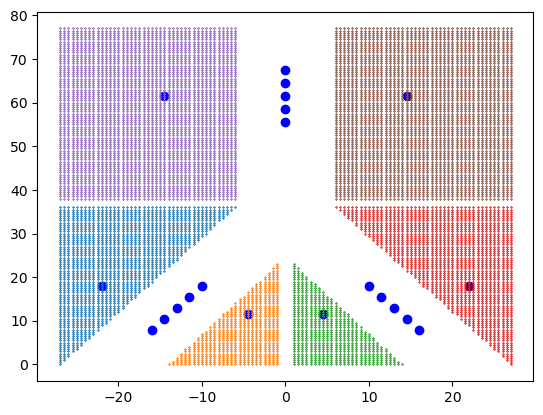

In [6]:
site_coords = system.grid_points[system.site_indices]
for gate, index in system.indices.items():
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [7]:
kwant_sites = np.array(list(site.pos for site in system.trijunction.sites))

In [9]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

#### Optimize potential shape

In [ ]:
optimal_voltages = {}
optimal_phase = {}
for pair in ['left-right', 'left-top', 'right-top']:
    
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params['dep_acc_index'] = system.indices

    args = (pair.split('-'),
            (system.base_ham, system.linear_terms, system.densityoperator),
            system.indices, 
            )

    initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

    sol1 = minimize(codes.optimization.shape_loss, 
             x0=initial_condition, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )

    print('Potential')

    ci, wf_amp = 50, 1e-4
    args = ((system.base_ham, 
            params, 
            system.linear_terms, 
            system.f_params, 
            system.densityoperator),
            (pair.split('-'), system.indices, (ci, wf_amp))
           )

    sol2 = minimize(codes.optimization.wavefunction_loss, 
             x0=sol1.x, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )

    print('Non-zero couplings')

    params.update(parameters.voltage_dict(sol2.x))
    
    args = (pair, 
            params, 
            (system.trijunction, system.linear_terms, 
             system.f_params, system.densityoperator, 
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol3 = minimize_scalar(codes.optimization.loss, 
                             args=args, 
                             method='bounded', 
                             bounds=(0,2)
                          )

    
    optimal_phase[pair] = sol3.x * np.pi
    
    print(optimal_phase[pair])

    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    

    args = (pair, 
            params, 
            (system.base_ham, system.linear_terms, 
             system.f_params, system.densityoperator, 
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol4 = minimize(codes.optimization.loss, 
             x0=sol2.x, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )
    
    optimal_voltages[pair] = parameters.voltage_dict(sol4.x)
    
    print(optimal_voltages[pair])

Potential
Non-zero couplings
4.312837043705278


#### Results

In [30]:
pair = 'left-right'

left-right: [-0.00346951 -0.00346951 -0.01953967  0.00989012]
left-top: [-0.00353362 -0.01716022 -0.00417007  0.01126552]
right-top: [-0.01289892 -0.00305624 -0.00377927  0.00875192]


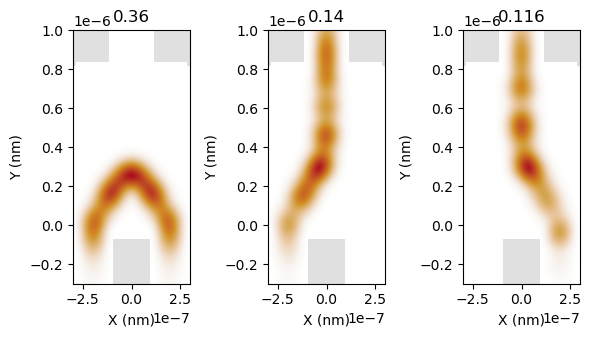

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(6, 4))

for i, pair in enumerate(['left-right', 'left-top', 'right-top']):
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params.update(optimal_voltages[pair])
    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))

    linear_ham, full_ham = hamiltonian(system.base_ham, 
                                   system.linear_terms, 
                                   system.f_params, 
                                   **params)

    potential = linear_ham.diagonal()[::4]
    # step_potential = np.array(np.abs(potential) > bands[0], dtype=int)

    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    transformed_hamiltonian = svd_transformation(
        evals, evecs, system.mlwf[order_wavefunctions(pair)]
    )

    desired = np.abs(transformed_hamiltonian[0, 1])
    undesired = np.linalg.norm(transformed_hamiltonian[2:])

    wfv = system.densityoperator(evecs[:, 0])

    # kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
    kwant.plotter.density(system.trijunction, wfv, ax=ax[i]);
    ax[i].set_title(np.round(desired/topological_gap, 3))
    # for value in system.indices.values():
    #     ax[0].scatter(*kwant_sites[value], c='blue')
    
    voltages = list(optimal_voltages[pair].values())
    print(pair + ':', np.array(voltages)[list(range(0, 7, 2))])
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)
    axes.set_xlabel('X (nm)')
    axes.set_ylabel('Y (nm)')
    
fig.tight_layout()